# Where to Intervene Example
This notebook contains a simple example of a bow graph with an instrument variable where the optimal policy scope is to only intervene on the instrument variable instead of intervening on both actions. 
The example set up follows the CausalAI textbook chapter 9 section 9.3.1 example 9.5.

In [1]:
import numpy as np

from causal_gym.envs import ExamplePCH_9_5, ExampleSCM_9_5
from causal_rl.algo.where_do.where_do import WhereDo
from causal_rl.algo.where_do.utils_wheredo import flatten
from causal_gym import SCM, PCH, Task, Graph

import multiprocess as mp
from multiprocess import Process

## Example 9.5
Consider a MAB environment $\mathcal{M}^*$ described by an SCM:
$$\mathcal{M}^* = \langle \boldsymbol{U} = \{U_{1}, U_{2}\}, \boldsymbol{V} = \{X_1, X_1, Y\}, \mathcal{F} = \{\mathcal{F}_i\}, P(\boldsymbol{U})\rangle $$

where $U_{i,1}, U_{i,2}, U_{i,3}$ represent, respectively, human erros when stocking the inventory, and uncertainties indemand, and monetary values of the goods. The causal mechanisms $\mathcal{F}_i$ representing the system dynamics transitioning from day $i-1$ to $i$ are defined as:
$$\mathcal{F} =
\begin{cases}
X_1 \gets U_{1},\\
X_2 \gets X_{1} \oplus U_{2},\\
Y \gets X_{2} \oplus U_{2}
\end{cases}$$

and $P(\boldsymbol{U})$ is the distribution of binary variables $\{U_{1}, U_{2}\}$. They are independent variables drawn from $P(U_{1} = 1)= P(U_{2}=1) =.5$.

The causal graph entailed by $\mathcal{M}^*$ is as follows:

![image.png](image.png)

### Evaluating behavioral policy
From the example, we have the following mixed policy space: by $\langle \{\},\{X_1\},\{X_2\}, \{X_1, X_2\} \rangle$. Policy space $\{\}$ corresponds to the behavioral policy,

$$\mathbb{E}[Y] = \mathbb{E}[(X_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = 0.5.$$

We first simulate the behavioral policy by performing see() and verify if its performance is indeed approximately $0.5$.

In [2]:
TEST_EPI = 50000
results = []
for i in range(TEST_EPI):
    env = ExamplePCH_9_5(task=Task(learning_regime='see'))
    _, _ = env.reset()
    done = False
    _, y, _, done, info = env.see()
    x1, x2 = info['natural_action']
    assert done, "this should be a single step env"
    results.append(y)

print(f'Avg return for behavioral policy is {sum(results)/len(results)}')


Avg return for behavioral policy is 0.5005


### Evaluating Optimal Atomic Policy

Next, we check the performance of two interventional policies, do($x_1$) and do($x_2$) (do($x_1, x_2$)), and estimate their performance by running TEST_EPI number of episodes.
$$\mathbb{E}[Y|\textit{do}(x_1)] = \mathbb{E}[(x_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = x_1$$
$$\mathbb{E}[Y|\textit{do}(x_1, x_2)] = \mathbb{E}[Y|\textit{do}(x_2)] = \mathbb{E}[x_2\oplus U_{X_2,Y}] = 0.5(x_2) + 0.5(1-x_2) = 0.5$$

Clearly, a better interventional policy that takes action $X_1 \leftarrow 1$ can achieve an expected reward of $$\mathbb{E}[Y|\textit{do}(x_1=1)] = \mathbb{E}[(x_1\oplus U_{X_2,Y})\oplus U_{X_2,Y}] = x_1 $$

Thus, if we evaluate this interventional policy for infinitely long, we would have an average reuturn of,
$$\mathbb{E}[Y|\textit{do}(x_1=1)] = 1.0$$

In [3]:
# The interventional policy
def dox1(obs):
    return {'X1': 1}

def dox2(obs):
    return {'X2': 1}

TEST_EPI = 50000
results = []
for i in range(TEST_EPI):
    env = ExamplePCH_9_5(task=Task(learning_regime='do'))
    _, _ = env.reset()
    done = False
    _, y, _, done, info = env.do(do_policy=dox1)
    x1, x2 = info['action']
    assert done, "this should be a single step env"
    results.append(y)

print(f'Avg return for do(X1=1) is  {sum(results)/len(results)}')

results = []
for i in range(TEST_EPI):
    env = ExamplePCH_9_5(task=Task(learning_regime='do'))
    _, _ = env.reset()
    done = False
    _, y, _, done, info = env.do(do_policy=dox2)
    x1, x2 = info['action']
    assert done, "this should be a single step env"
    results.append(y)

print(f'Avg return for do(X2=1) is  {sum(results)/len(results)}')

Avg return for do(X1=1) is  1.0
Avg return for do(X2=1) is  0.5031


### Where to Intervene
Next, we will visualize the result of running the where to intervene algorithm on the causal diagram of this example.

The interventional border is: X1


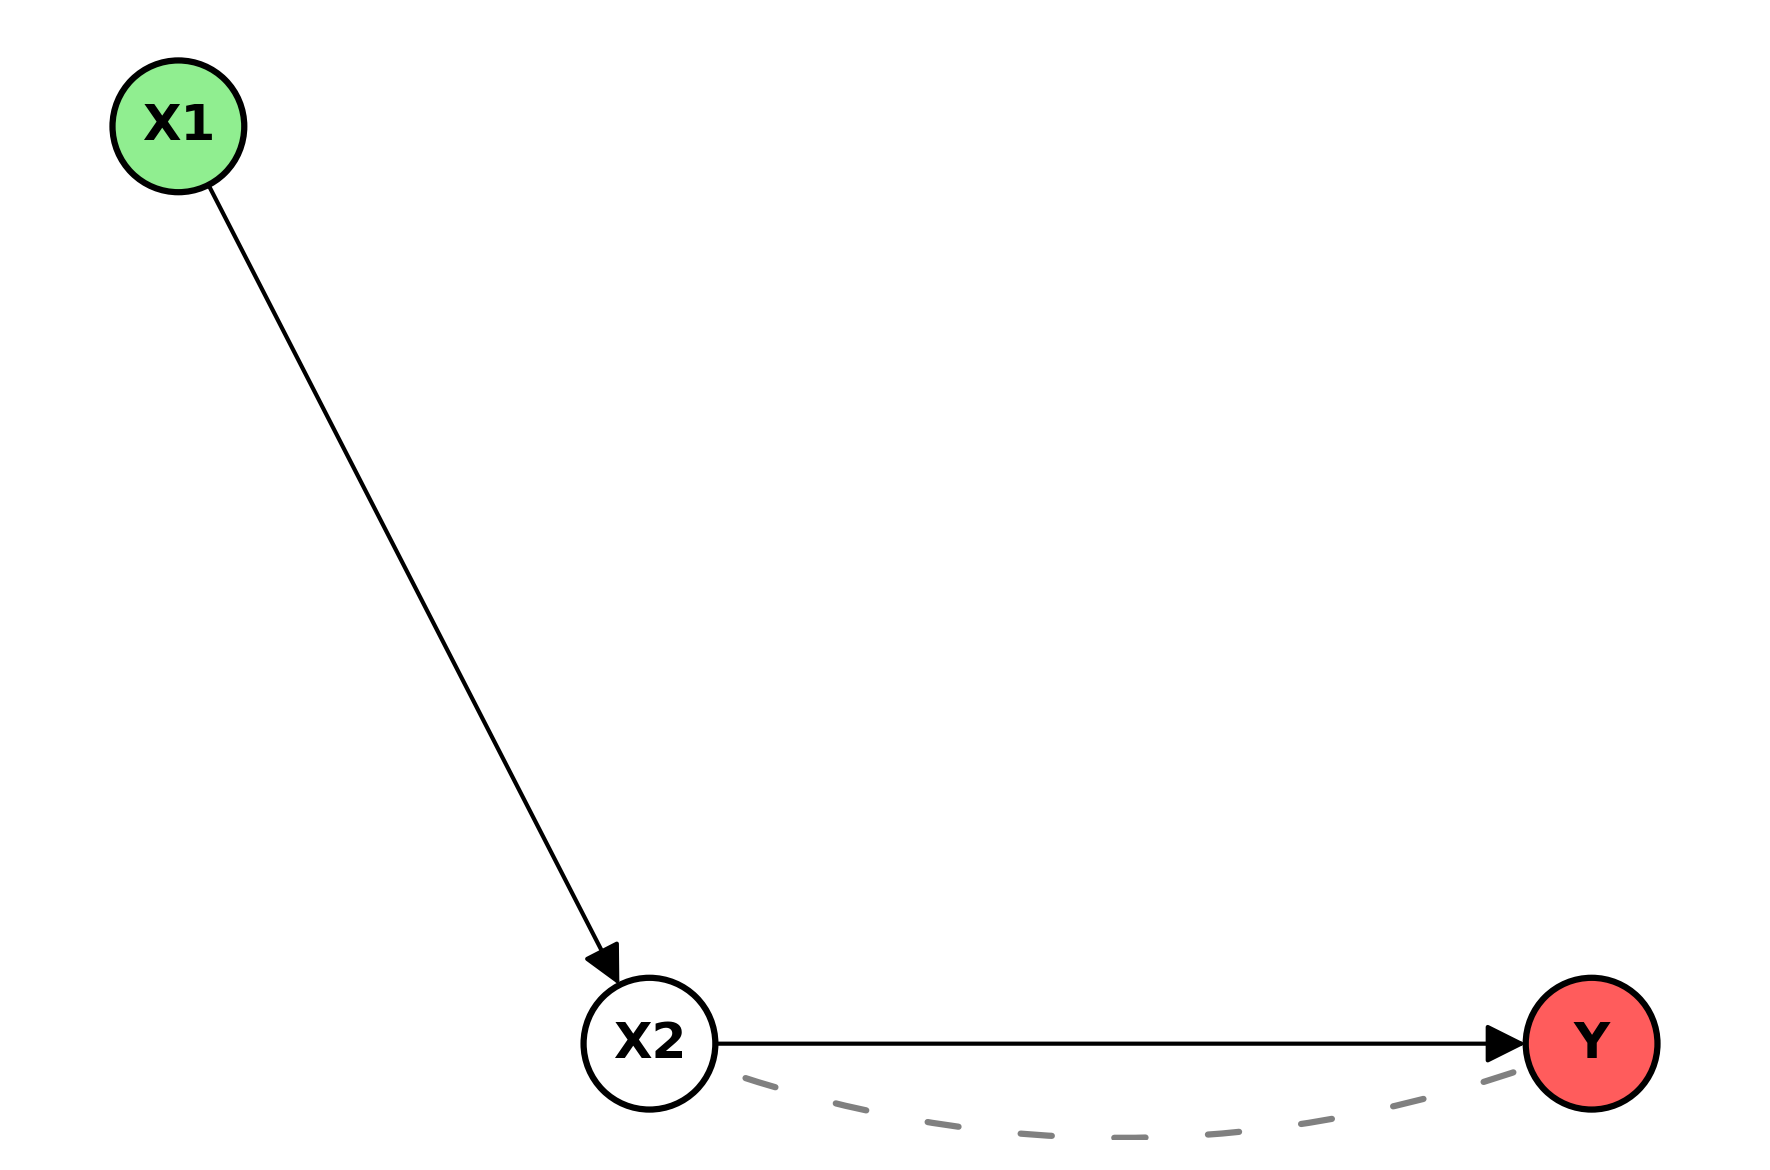

In [12]:
# Set the colors
from causal_rl.algo.where_do.graph import graph_to_vizdag
colors = {
    'intervention': '#199fff',
    'MUCT': 'lightblue',
    'IB': '#90ee90',
    'target': '#ff5c5c',
    'others': '#ffffff'
}

graph = ExampleSCM_9_5().get_graph()
cdag = graph_to_vizdag(graph)
pos = {'X1':(0.6,1.4),
       'X2':(0.7,1.3),
       'Y':(0.9,1.3)}
task = WhereDo()
Y = 'Y'
print("The interventional border is: X1")
cdag.nx_viz(
    path='./ib.png',
    pos=pos, 
    node_size=1000,
    node_color_map = {colors['target']:'Y', colors['IB']:flatten(task.IB(cdag, 'Y'))}
)[0]

The Minimum Unobserved Confounders' Territory is {X2, Y}


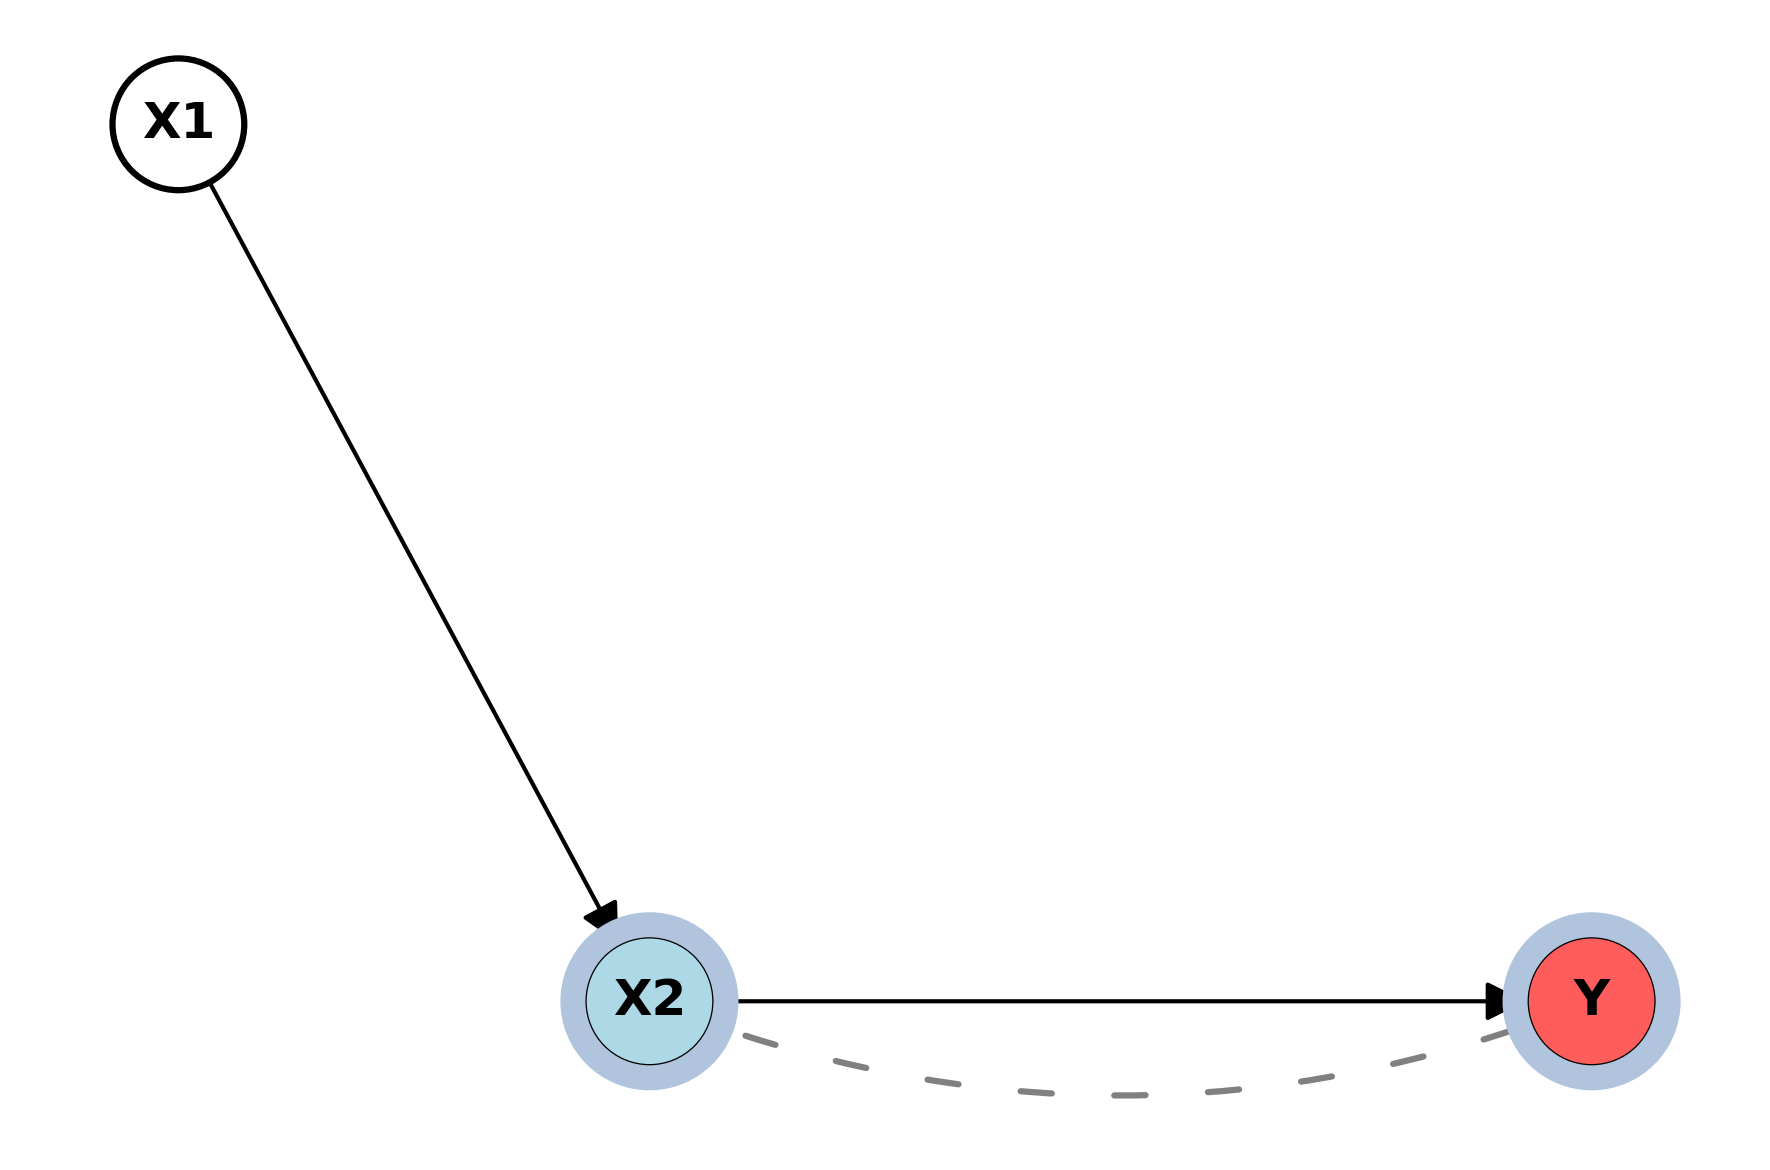

In [11]:
print("The Minimum Unobserved Confounders' Territory is {X2, Y}")
cdag.nx_viz(
    path='./muct.png',
    pos=pos, 
    node_size=1000,
    node_color_map = {colors['MUCT']:flatten(task.MUCT(cdag, 'Y')), colors['target']:'Y'}
)[0]